In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime as dt
from datetime import timedelta
import yfinance as yf

In [2]:
def get_data(stocks, start, end):
    stock_data = yf.download(stocks, start, end)
    stock_data = stock_data['Close']
    returns = stock_data.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix

pf = ['AAPL', 'SHEL', 'JPM', 'COST']
pf_size = len(pf)
mean_returns, cov_matrix = get_data(pf, dt.now() - timedelta(days=300), dt.now())

display(mean_returns)
display(cov_matrix)

[*********************100%***********************]  4 of 4 completed


Ticker
AAPL    0.001645
COST    0.001482
JPM     0.001396
SHEL   -0.000113
dtype: float64

Ticker,AAPL,COST,JPM,SHEL
Ticker,,,,
AAPL,0.000214,5.053472e-05,-0.000005,5.714586e-06
COST,0.000051,1.532177e-04,0.000027,6.598409e-07
JPM,-0.000005,2.732613e-05,0.000245,2.869511e-05
SHEL,0.000006,6.598409e-07,0.000029,1.196448e-04


In [3]:
weights = np.random.random(pf_size)
weights /= np.sum(weights)
display(weights)

array([0.19411714, 0.31058641, 0.37521117, 0.12008528])

In [4]:
mc_sims = 500 # number of simulations
T = 100 # time frame or steps

In [5]:
mean_m = np.full(shape=(T, pf_size), fill_value=mean_returns)
mean_m = mean_m.T
display(mean_m.shape)

(4, 100)

In [6]:
poftfolio_sims = np.full(shape=(T, mc_sims), fill_value=0)
initial_portfolio = 10000

In [7]:
for m in range(mc_sims):
    Z = np.random.normal(size=(T, pf_size))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = mean_m + np.inner(L, Z)
    poftfolio_sims[:,m] = np.cumprod(np.inner(weights, daily_returns.T) + 1) * initial_portfolio
    # display((np.inner(weights, daily_returns.T) + 1))
    # display(np.cumprod(np.inner(weights, daily_returns.T) + 1))

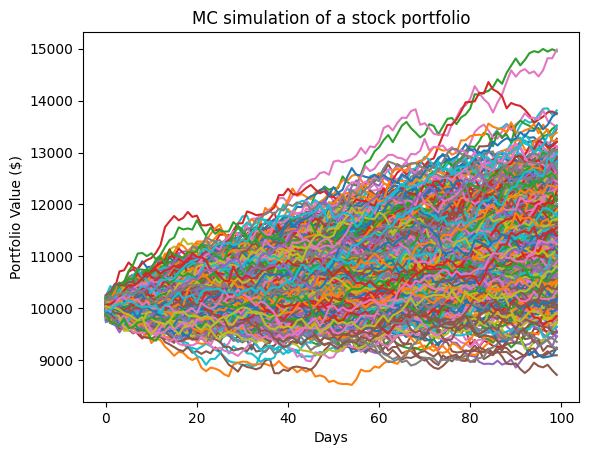

In [8]:
plt.plot(poftfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()


In [9]:
## Pricing option based on the portfolio analysis

# Get the payoff matrix
K = 10500
r = 0.3
payoff = np.maximum(poftfolio_sims[-1,:]- K, 0)
display(payoff)

array([1277,  668,    0, 2297, 2237,  884,  355,   84,  261,    0,  749,
        189, 1317, 2608,  758, 1104, 1093, 1789,   46,    0, 1348, 1071,
        934,  435,  678,  742, 2176, 2950,  666,  387,  757, 2417,  851,
        836,  783, 1774, 1774,    0, 2152,    0, 1058,  640,  804,  525,
       1032, 1397, 1327,   23,  211, 1699,    0,  442,    0,  772,  978,
          0, 1146,  697,   74, 1162, 1508, 2137,  773,  477,  962,  919,
          0, 1203, 1162,    0, 2305, 1653,  579, 1667,  149,  184,  475,
       1359,    0, 1408,  321,  459,  179,  392, 1448, 1322,  463,  656,
        830, 2522, 1324,  643, 4449,    0,    0, 2767, 2627,  960,   93,
        129,   77,    0, 1051, 1878, 1157,  473, 4481,   35,  673,    0,
       1056,  426,  643, 1360,    0, 2041,  573, 1871, 2335, 2113, 1183,
        743,    0, 1001,  371,    0, 2437,  875,    0, 1335, 2718,  409,
       1765, 1291, 2564, 1040, 1156,    0,    0, 3311,  133, 1661, 1332,
        761,    0,    0,   14,  661, 1255,  732,  5

In [10]:
cashflow_overtime = np.full(shape=(T, mc_sims), fill_value=0.0)
for time in range(T-1, 0, -1):
    if time == T-1:
        cashflow = payoff
    else:
        cashflow = cashflow * np.exp(-r*(T-time)/365)
    cashflow_overtime[time, :] = cashflow

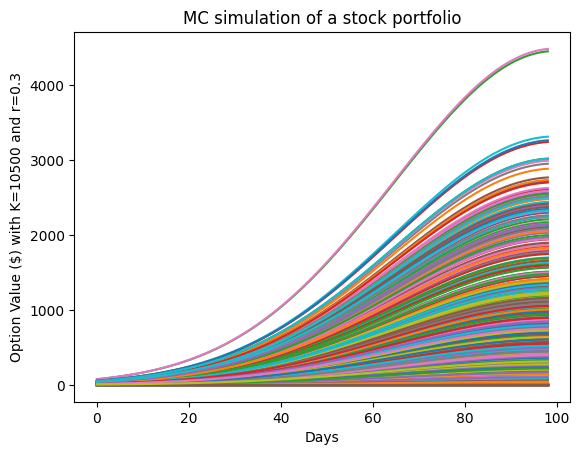

'The value of the option on portfolio with strike-price 10500 for Time-to-expiry 100 days : 16.122523380140926'

In [11]:
plt.plot(cashflow_overtime[1:])
plt.ylabel(f"Option Value ($) with K={K} and r={r}")
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

display(f"The value of the option on portfolio with strike-price {K} for Time-to-expiry {T} days : {np.mean(cashflow_overtime[1])}")

In [12]:
def var(distribution, confidence):
    try:
        return np.percentile(distribution, confidence)
    except:
        raise("Failed to Calculate VaR")

def expected_shortfall(distribution, confidence):
    try:
        value = var(distribution, confidence)
        return np.mean(distribution[distribution <= value]), value
    except:
        raise("Failed to Calulate VaR and ES")

expected_shortfall(poftfolio_sims[-1], 99)

(11327.721212121212, 13521.209999999997)